### Description of Variables
The dataset contains 6366 observations of 9 variables:
- rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
- age: woman's age
- yrs_married: number of years married
- children: number of children
- religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
- educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
- occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
- occupation_husb: husband's occupation (same coding as above)
- affairs: time spent in extra-marital affairs

### Problem Statement
I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/home/renjith/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
dta = sm.datasets.fair.load_pandas().data
dta['affair'] = (dta.affairs > 0).astype(int)

In [5]:
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [6]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [7]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


In [8]:
dta.shape

(6366, 10)

In [9]:
%matplotlib inline

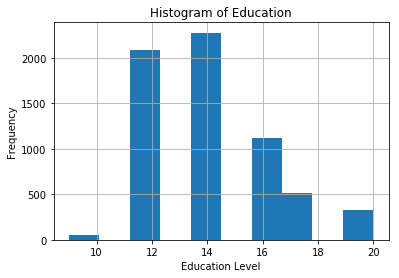

In [10]:
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

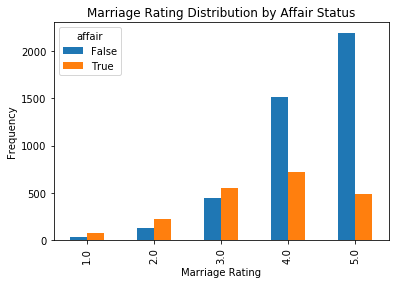

In [12]:
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

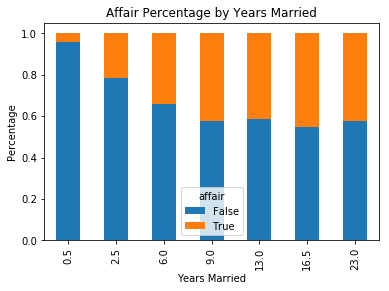

In [17]:
affairs_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affairs_yrs_married.div(affairs_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

### Prepare data for logistic regression

In [20]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                dta, return_type="dataframe")

In [21]:
 print X.columns

Index([u'Intercept', u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]',
       u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]',
       u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]',
       u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]',
       u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]',
       u'rate_marriage', u'age', u'yrs_married', u'children', u'religious',
       u'educ'],
      dtype='object')


In [22]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [23]:
y = np.ravel(y)

In [24]:
model = LogisticRegression()
model = model.fit(X,y)

In [25]:
model.score(X, y)

0.72588752748978946

In [26]:
y.mean()

0.32249450204209867

In [27]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.49262351657]
1,occ_2,[0.18804663378]
2,occ_3,[0.49890692397]
3,occ_4,[0.250957716695]
4,occ_5,[0.839047903197]
5,occ_6,[0.835409721888]
6,occ_husb_2,[0.1880783745]
7,occ_husb_3,[0.295327852365]
8,occ_husb_4,[0.158939429445]
9,occ_husb_5,[0.185347724259]


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [29]:
model2 = LogisticRegression()

In [30]:
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
predicted = model2.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


In [34]:
probs = model2.predict_proba(X_test)
print probs

[[ 0.3514255   0.6485745 ]
 [ 0.9095254   0.0904746 ]
 [ 0.72576645  0.27423355]
 ..., 
 [ 0.55736907  0.44263093]
 [ 0.81213878  0.18786122]
 [ 0.74729574  0.25270426]]


In [35]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.729842931937
0.74596198609


In [36]:
print metrics.confusion_matrix(y_test, predicted)

[[1169  134]
 [ 382  225]]


In [37]:
print metrics.classification_report(y_test, predicted)

             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



### Model evaluation using cross validation

In [38]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)

In [39]:
print scores
print scores.mean()

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


In [40]:
model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4, 16]))

/home/renjith/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.7747467,  0.2252533]])